## Setting

In [37]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import imp
import importlib
sys.path.append("/content/drive/My Drive/LCNN/")


Mounted at /content/drive


In [38]:
sys.path.append("./../")

import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot,adjust_
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

batchsize=64
dataset_dir = '/home/liu0003/Desktop/datasets'

trainset = datasets.MNIST(dataset_dir, download=True, train=True, transform=transform)
valset = datasets.MNIST(dataset_dir, download=True, train=False, transform=transform)



train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False, sampler=SubsetRandomSampler(range(batchsize)), worker_init_fn=np.random.seed(0))
test_loader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False, worker_init_fn=np.random.seed(0))

Extracting /home/liu0003/Desktop/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /home/liu0003/Desktop/datasets/MNIST/raw


Extracting /home/liu0003/Desktop/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /home/liu0003/Desktop/datasets/MNIST/raw


Extracting /home/liu0003/Desktop/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/liu0003/Desktop/datasets/MNIST/raw




Extracting /home/liu0003/Desktop/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/liu0003/Desktop/datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 2 layers network

In [39]:
class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False):
        super(NeuralNet2layer, self).__init__()
        self.initialize=initialize
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.batchnorm = batchnorm

        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        if self.initialize=='NTK':

            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)

            
    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        else:

            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        return out
    
    
     

def loss_and_accuracy(model,loader, criterion, acc_bool = False):
# def loss_and_accuracy(model,loader, criterion):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    t=0
    c=0
    total_loss = 0
    
    model.eval()

    with torch.no_grad():    
        if not acc_bool:
            for i, (images, labels) in enumerate(loader):
                images = images.view(images.shape[0], -1).to(device)
                outputs = model(images)
                loss = criterion(outputs, one_hot(labels, 10)).to(device)
                total_loss += loss

                c=c+len(outputs)
            return total_loss/c
        
        else: 
            for i, (images, labels) in enumerate(loader):
                images = images.view(images.shape[0], -1).to(device)
                outputs = model(images)
                loss = criterion(outputs, one_hot(labels, 10)).to(device)
                total_loss += loss
                
                t=t+(torch.argmax(outputs,dim=1) == labels).float().sum()
                c=c+len(outputs)
            return t/c*100 , total_loss/c


def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
    
def plot_loss_acc(step_list, loss_dict, acc_dict, title, fig_save_path):
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))


    axs[0].plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
    axs[0].plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
    axs[0].legend(frameon = False, fontsize = 12)
    axs[0].set_xlabel('Iter num', fontsize = 15)
    axs[0].set_ylabel('Loss', fontsize = 15)


    axs[1].plot(step_list, acc_dict['train'], label = 'train', linewidth = 3, linestyle =  '--')
    axs[1].plot(step_list, acc_dict['test'], label = 'test', linewidth = 3)
    axs[1].legend(frameon = False, fontsize = 12)
    axs[1].set_xlabel('Iter num', fontsize = 15)
    axs[1].set_ylabel('Acc', fontsize = 15)


#     title = '784-800-10; no scaling; no bn; full batch; train data size = 64'
    plt.suptitle(title, fontsize = 17)

    axs[0] = simpleaxis(axs[0])
    axs[1] = simpleaxis(axs[1])
    plt.subplots_adjust(bottom=0.2)
    plt.savefig(fig_save_path + title, format='png')
    
    return fig


def plot_loss(step_list, loss_dict, title, fig_save_path):
    
    fig, axs = plt.subplots(1, figsize=(4, 3))


    axs.plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
    axs.plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
    axs.legend(frameon = False, fontsize = 12)
    axs.set_xlabel('Iter num', fontsize = 15)
    axs.set_ylabel('Loss', fontsize = 15)

    plt.suptitle(title, fontsize = 17)

    axs = simpleaxis(axs)
    plt.subplots_adjust(bottom=0.2)
#     plt.savefig(fig_save_path + title, format='png')
    
    return fig

In [40]:
total_run_steps = 50

store_every = 10

shared_model_param_dict = {'input_size': 784, 'hidden_size1': 800, 'num_classes': 10, 
                           'total_run_steps': total_run_steps, 'criterion': nn.MSELoss(), 
                         'train_loader': train_loader, 'test_loader': test_loader, 
                          'store_every': store_every, 'weight_decay': 0}

fig_save_path = './Figures/fullbatch/'

In [41]:
def full_batch_train(initialize, batchnorm, learning_rate, weight_decay, input_size, hidden_size1, num_classes, criterion, total_run_steps, train_loader, test_loader, store_every  ):
    images, labels = next(iter(train_loader))
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels, 10).to(device)

    torch.manual_seed(0)
    model = NeuralNet2layer(input_size = input_size, hidden_size1 = hidden_size1, num_classes = num_classes, initialize=initialize,batchnorm = batchnorm).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay = weight_decay)


    train_losslist=[]
#     train_aclist=[]

    test_losslist=[]
#     test_aclist=[]
    
    iter_list = []
    
    for runsteps in range(total_run_steps):
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if runsteps%store_every==0 or runsteps<store_every:  
            iter_list.append(runsteps)
            train_loss = loss_and_accuracy(model, train_loader , criterion)
            test_loss = loss_and_accuracy(model, test_loader , criterion)

            train_losslist.append(train_loss)
#             train_aclist.append(train_ac)

            test_losslist.append(test_loss)
#             test_aclist.append(test_ac)

#             print ('Iter: %03d/%03d | Train Loss: %.8f | Train acc: %.4f' %(runsteps, total_run_steps, train_loss, train_ac))   
            print ('Iter: %03d/%03d | Train Loss: %.8f' %(runsteps, total_run_steps, train_loss))   

    loss_dict = {'train': train_losslist, 'test': test_losslist}
    
    train_ac, train_loss = loss_and_accuracy(model, train_loader , criterion, acc_bool = True)
    test_ac, test_loss = loss_and_accuracy(model, test_loader , criterion, acc_bool = True)
    
#     acl_dict = {'train': train_aclist, 'test': test_aclist}
    print()
    print('Iter: %03d/%03d | Test Loss: %.8f | Test acc: %.4f' %(runsteps, total_run_steps, test_loss, test_ac) )
#     return iter_list, loss_dict, acl_dict
    return iter_list, loss_dict, train_loss

In [42]:
def full_batch_train_(scale,therd,mode,initialize, batchnorm, learning_rate, weight_decay, input_size, hidden_size1, num_classes, criterion, total_run_steps, train_loader, test_loader, store_every):
    images, labels = next(iter(train_loader))
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels, 10).to(device)

    torch.manual_seed(0)
    model = NeuralNet2layer(input_size = input_size, hidden_size1 = hidden_size1, num_classes = num_classes, initialize=initialize,batchnorm = batchnorm).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay = weight_decay)


    train_losslist=[]
#     train_aclist=[]

    test_losslist=[]
#     test_aclist=[]
    
    iter_list = []
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    for runsteps in range(total_run_steps):
        if (runsteps==0):
            model.fc1.register_forward_hook(get_activation('fc1'))
            outputs=model(images).to(device)
            adjust_(model,activation['fc1'],images,threshold_u=1.0/therd,threshold_l=therd,scale=scale,ln=1,oflag=1,mode=mode,shuff=0)



        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if runsteps%store_every==0 or runsteps<store_every: 
            iter_list.append(runsteps)
            train_loss = loss_and_accuracy(model, train_loader , criterion)
            test_loss = loss_and_accuracy(model, test_loader , criterion)

            train_losslist.append(train_loss)
#             train_aclist.append(train_ac)

            test_losslist.append(test_loss)
#             test_aclist.append(test_ac)

#             print ('Iter: %03d/%03d | Train Loss: %.8f | Train acc: %.4f' %(runsteps, total_run_steps, train_loss, train_ac))   
            print ('Iter: %03d/%03d | Train Loss: %.8f' %(runsteps, total_run_steps, train_loss))   

    loss_dict = {'train': train_losslist, 'test': test_losslist}
    
    train_ac, train_loss = loss_and_accuracy(model, train_loader , criterion, acc_bool = True)
    test_ac, test_loss = loss_and_accuracy(model, test_loader , criterion, acc_bool = True)
    
#     acl_dict = {'train': train_aclist, 'test': test_aclist}
    print()
    print('Iter: %03d/%03d | Test Loss: %.8f | Test acc: %.4f' %(runsteps, total_run_steps, test_loss, test_ac) )
#     return iter_list, loss_dict, acl_dict
    return iter_list, loss_dict,train_loss

In [ ]:
maxstep=1000
for scale in range(10):
    scale=(scale-2)*0.05+1.2
    for therd in range(10):
        therd=(therd-2)*0.05+0.7
        print('scale:{:03f},therd:{:03f}'.format(scale,therd))
        step_list, loss_no_scale_no_bn,train_loss = full_batch_train_(scale,therd,0,initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)
        if maxstep>train_loss:
            maxstep=train_loss
            sb=scale
            th=therd
print(maxstep,sb,th)

scale:1.100000,therd:0.600000
Adjusting Layer 1, Kernel Nodes: 655, Adptive Nodes:145
Iter: 000/050 | Train Loss: 0.00721748
Iter: 001/050 | Train Loss: 0.01545886
Iter: 002/050 | Train Loss: 0.00120714
Iter: 003/050 | Train Loss: 0.00125340
Iter: 004/050 | Train Loss: 0.00117639
Iter: 005/050 | Train Loss: 0.00109982
Iter: 006/050 | Train Loss: 0.00102151
Iter: 007/050 | Train Loss: 0.00095017
Iter: 008/050 | Train Loss: 0.00088630
Iter: 009/050 | Train Loss: 0.00082463
Iter: 010/050 | Train Loss: 0.00075102
Iter: 020/050 | Train Loss: 0.00032237
Iter: 030/050 | Train Loss: 0.00011570
Iter: 040/050 | Train Loss: 0.00003935

Iter: 049/050 | Test Loss: 0.00096493 | Test acc: 63.5700
scale:1.100000,therd:0.650000
Adjusting Layer 1, Kernel Nodes: 655, Adptive Nodes:145
Iter: 000/050 | Train Loss: 0.00590524
Iter: 001/050 | Train Loss: 0.00881829
Iter: 002/050 | Train Loss: 0.00116509
Iter: 003/050 | Train Loss: 0.00118261
Iter: 004/050 | Train Loss: 0.00106544
Iter: 005/050 | Train Loss: 

In [32]:
maxstep.cpu().numpy()

array(0.00091463, dtype=float32)

# No scaling, no batch norm

In [49]:
step_list_, loss_no_scale_no_bn_,train_loss = full_batch_train_(1.2,0.7,0,initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)
print(train_loss)

Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes:151
Iter: 000/050 | Train Loss: 0.00490965
Iter: 001/050 | Train Loss: 0.00501630
Iter: 002/050 | Train Loss: 0.00119303
Iter: 003/050 | Train Loss: 0.00110480
Iter: 004/050 | Train Loss: 0.00099091
Iter: 005/050 | Train Loss: 0.00086961
Iter: 006/050 | Train Loss: 0.00078935
Iter: 007/050 | Train Loss: 0.00073250
Iter: 008/050 | Train Loss: 0.00068311
Iter: 009/050 | Train Loss: 0.00063689
Iter: 010/050 | Train Loss: 0.00057806
Iter: 020/050 | Train Loss: 0.00020454
Iter: 030/050 | Train Loss: 0.00006629
Iter: 040/050 | Train Loss: 0.00002226

Iter: 049/050 | Test Loss: 0.00093844 | Test acc: 64.5800
tensor(8.9210e-06)


In [65]:
step_list_original, loss_no_scale_no_bn_original,train_loss_original= full_batch_train(initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)
print(train_loss)

Iter: 000/050 | Train Loss: 0.00340580
Iter: 001/050 | Train Loss: 0.00159687
Iter: 002/050 | Train Loss: 0.00157065
Iter: 003/050 | Train Loss: 0.00082164
Iter: 004/050 | Train Loss: 0.00092534
Iter: 005/050 | Train Loss: 0.00077363
Iter: 006/050 | Train Loss: 0.00056668
Iter: 007/050 | Train Loss: 0.00053111
Iter: 008/050 | Train Loss: 0.00055974
Iter: 009/050 | Train Loss: 0.00052726
Iter: 010/050 | Train Loss: 0.00043010
Iter: 020/050 | Train Loss: 0.00013146
Iter: 030/050 | Train Loss: 0.00004146
Iter: 040/050 | Train Loss: 0.00001400

Iter: 049/050 | Test Loss: 0.00091591 | Test acc: 65.9700
tensor(4.9190e-06)


In [ ]:
tensor(4.9190e-06) 0.1

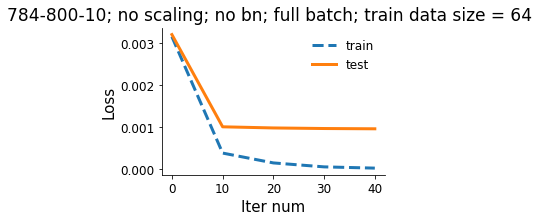

In [ ]:
title = '784-800-10; no scaling; no bn; full batch; train data size = 64'
# fig = plot_loss_acc(step_list, loss_no_scale_no_bn, aclist_no_scale_no_bn, title, fig_save_path)
fig = plot_loss(step_list, loss_no_scale_no_bn, title, fig_save_path)

del title

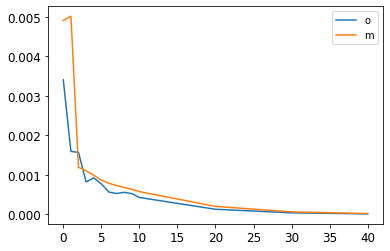

In [63]:
plt.plot(step_list,loss_no_scale_no_bn['train'],label='o')
plt.plot(step_list_,loss_no_scale_no_bn_['train'],label='m')
plt.legend()

# No scaling + batch norm

In [ ]:
step_list, loss_no_scale_bn = full_batch_train(initialize = 'LeCun', batchnorm = True, learning_rate = 0.1, ** shared_model_param_dict)

Iter: 000/050 | Train Loss: 0.00159749
Iter: 010/050 | Train Loss: 0.00041908
Iter: 020/050 | Train Loss: 0.00011016
Iter: 030/050 | Train Loss: 0.00003261
Iter: 040/050 | Train Loss: 0.00001222

Iter: 049/050 | Test Loss: 0.00093564 | Test acc: 65.9500


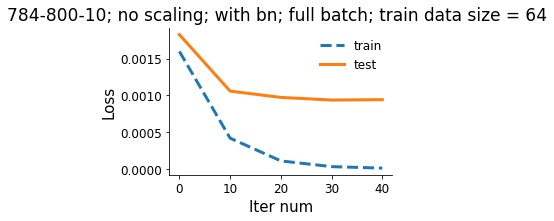

In [ ]:
title = '784-800-10; no scaling; with bn; full batch; train data size = 64'
fig = plot_loss(step_list, loss_no_scale_bn, title, fig_save_path)
del title

# NTK scaling, no batch norm

In [ ]:
step_list,  loss_ntk_scale_no_bn = full_batch_train(initialize = 'NTK', batchnorm = False, learning_rate = 0.1 * np.sqrt(784), ** shared_model_param_dict)

Iter: 000/050 | Train Loss: 0.00195354
Iter: 010/050 | Train Loss: 0.00131614
Iter: 020/050 | Train Loss: 0.00096557
Iter: 030/050 | Train Loss: 0.00076219
Iter: 040/050 | Train Loss: 0.00062788

Iter: 049/050 | Test Loss: 0.00109896 | Test acc: 54.7000


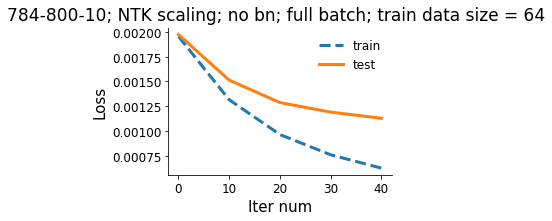

In [ ]:
title = '784-800-10; NTK scaling; no bn; full batch; train data size = 64'
fig = plot_loss(step_list, loss_ntk_scale_no_bn, title, fig_save_path)
del title

# NTK scaling + batch norm

In [ ]:
step_list,  loss_ntk_scale_bn =  full_batch_train(initialize = 'NTK', batchnorm = True, learning_rate =  0.1 * np.sqrt(784), ** shared_model_param_dict)

Iter: 000/050 | Train Loss: 0.00196346
Iter: 010/050 | Train Loss: 0.00115924
Iter: 020/050 | Train Loss: 0.00083341
Iter: 030/050 | Train Loss: 0.00061639
Iter: 040/050 | Train Loss: 0.00049927

Iter: 049/050 | Test Loss: 0.00107133 | Test acc: 57.7100


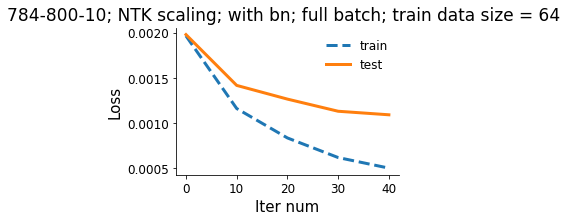

In [ ]:
title = '784-800-10; NTK scaling; with bn; full batch; train data size = 64'
fig = plot_loss(step_list, loss_ntk_scale_bn, title, fig_save_path)
del title

# Plot 

In [ ]:
loss_ntk_scale_bn

{'train': [tensor(0.0020),
  tensor(0.0012),
  tensor(0.0008),
  tensor(0.0006),
  tensor(0.0005)],
 'test': [tensor(0.0020),
  tensor(0.0014),
  tensor(0.0013),
  tensor(0.0011),
  tensor(0.0011)]}

In [ ]:
plot_dict = {'without scaling; without bn': loss_no_scale_no_bn,
            'without scaling; with bn': loss_no_scale_bn, 
            'NTK scaling; without bn': loss_ntk_scale_no_bn, 
            'NTK scaling; with bn': loss_ntk_scale_bn}



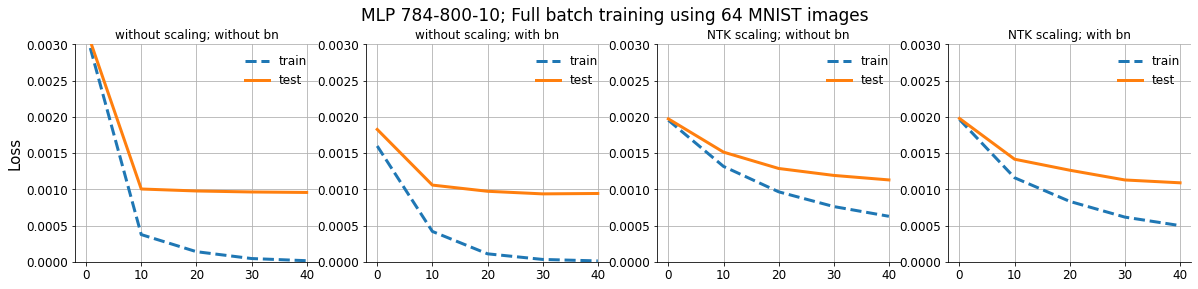

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# key_idx = 0
key_idx = 0
for title in list(plot_dict.keys()):
#     title = list(plot_dict.keys())[key_idx]
    loss_dict = plot_dict[title]

    axs[key_idx].plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
    axs[key_idx].plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
    axs[key_idx].legend(frameon = False, fontsize = 12)
    
    if key_idx == 0:
        axs[key_idx].set_ylabel('Loss', fontsize = 15)
    axs[key_idx].set_title(title)

    axs[key_idx].set_ylim([0, 0.003])   
    axs[key_idx].grid(True)
    
    axs[key_idx] = simpleaxis(axs[key_idx])

    plt.suptitle('MLP 784-800-10; Full batch training using 64 MNIST images', fontsize = 17, y = 1.01)
    key_idx += 1
    
    
# plt.savefig(fig_save_path + 'fullbatch', format='png')


In [ ]:
# plot_dict = {'without scaling; without bn': (loss_no_scale_no_bn, aclist_no_scale_no_bn),
#             'without scaling; with bn': (loss_no_scale_bn, aclist_no_scale_bn),
#             'NTK scaling; without bn': (loss_ntk_scale_no_bn, aclist_ntk_scale_no_bn),
#             'NTK scaling; with bn': (loss_ntk_scale_bn, aclist_ntk_scale_bn)}



# fig, axs = plt.subplots(2, 4, figsize=(20, 6))

# # key_idx = 0
# key_idx = 0
# for title in list(plot_dict.keys()):
# #     title = list(plot_dict.keys())[key_idx]
#     loss_dict, acc_dict = plot_dict[title]

#     axs[0, key_idx].plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
#     axs[0, key_idx].plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
#     axs[0, key_idx].legend(frameon = False, fontsize = 12)
    
#     if key_idx == 0:
#         axs[0, key_idx].set_ylabel('Loss', fontsize = 15)
#     axs[0, key_idx].set_title(title)

#     axs[1, key_idx].plot(step_list, acc_dict['train'], label = 'train', linewidth = 3, linestyle =  '--')
#     axs[1, key_idx].plot(step_list, acc_dict['test'], label = 'test', linewidth = 3)
#     axs[1, key_idx].legend(frameon = False, fontsize = 12)
#     axs[1, key_idx].set_xlabel('Iter num', fontsize = 15)
    
#     if key_idx == 0:
#         axs[1, key_idx].set_ylabel('Acc', fontsize = 15)

#     axs[0, key_idx].set_ylim([0, 0.003])   
#     axs[1, key_idx].set_ylim([40, 101])    
#     axs[0, key_idx].grid(True)
#     axs[1, key_idx].grid(True)
    
#     axs[0, key_idx] = simpleaxis(axs[0, key_idx])
#     axs[1, key_idx] = simpleaxis(axs[1, key_idx])

#     plt.suptitle('MLP 784-800-10; Full batch training using 64 MNIST images', fontsize = 17)
#     key_idx += 1
    
    
# plt.savefig(fig_save_path + 'fullbatch', format='png')
